#Land cover classification with Sentinel-1 time series
## Mort Canty
##ZFL Bonn, March, 2021


## Context
A big advantage of SAR satellite imagery over its optical/infrared counterparts is of course weather and solar illumination independence. But for land cover classification, SAR data are relatively insensitive to vegetation/crop differences. This can be at least partly compensated by making use of time series of SAR acquisitions over a complete growth period. In this part of the course we'll examine this possibility with Sentinel-1 images collected on the Google Earthengine. There are many alternative classifiers available, such as Bayes, random forest, support vector machine, etc. We will choose to work with a neural network, essentially because of its flexibility, but also because we will continue in the next part of the course with deep learning (i.e. neural network) methods.

### References
[Géron (2019) Hands-On Machine Learning ...](https://b-ok.cc/book/5341845/f49201)

[Canty (2109) Image Anaylsis, Classification and Change Detection ...](https://www.taylorfrancis.com/books/image-analysis-classification-change-detection-remote-sensing-morton-john-canty/10.1201/9780429464348)

[Moreira et al. (2013) A Tutorial on Synthetic Aperture Radar](https://elib.dlr.de/82313/)

### Software

[Colab notebooks](https://gist.github.com/mortcanty)

[Python scripts](https://drive.google.com/drive/folders/1D2RAEu14Zcl9NzqWkSg4J7MilHGHi0BH?usp=sharing)



## Feed forward neural networks in a nutshell

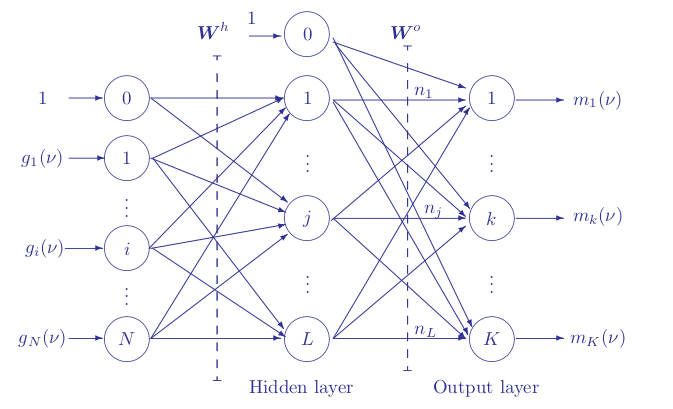

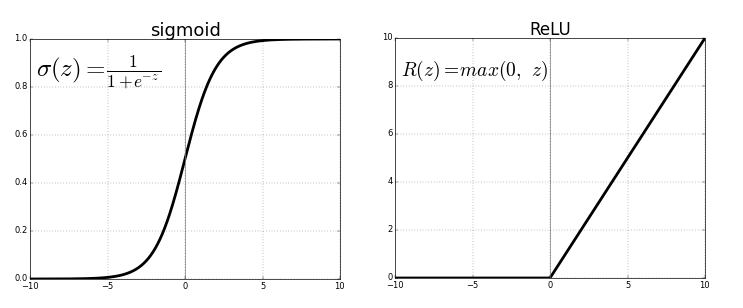



__Biased input vector__:

$$
g^\top = (1,g_1,\dots,g_N)
$$

__Sigmoid activation__ function (hidden layers, classical):

$$
n_j(g) = {1\over 1+ e^{-w^h_j\cdot g}},\quad j = 1 \dots L.
$$

__Regularized linear unit (relu) activation__ (hidden layers, more suitable for TensorFlow's autodifferentiation and for deep learning generally):

$$
n_j(g) = \max(0,w^h_j\cdot g),\quad j = 1 \dots L.
$$

__Softmax activation__ function (output layer):

$$
m_k(n) = { e^{w^o_k\cdot n}\over e^{w^o_1\cdot n}+ \dots e^{w^o_K\cdot n} }, \quad k = 1\dots K,
$$

which is called the _a posteriori_ probability of class $k$ given input $g$.


This simple model is in fact a __universal classifier__. To quote from the classic text [Neural Networks for Pattern Recognition, Bishop (1995)](https://www.amazon.com/Networks-Recognition-Advanced-Econometrics-Paperback/dp/0198538642):

... _in the context of a classification problem, networks
with sigmoidal non-linearities and two layers of weights can approximate any decision boundary to
arbitrary accuracy. ... More generally, the capability of such networks to approximate general smooth
functions allows them to model posterior probabilities of class membership._


__One hot label encoding__ for training example $g(\nu)$ in class 1:

$$
\ell^{(1)}(\nu) = (1,0,\dots, 0)
$$

In class 2:

$$
\ell^{(2)}(\nu) = (0,1,\dots, 0)
$$

and so on.
 
__Categorical cross entropy__ (loss function) for training example $g(\nu)$ in class $c$:

$$
E(w^h,w^o) = -\sum_k\ell^{(c)}_k(\nu)\log(m_k(\nu))
$$

The loss function in minimized over batches of training examples with respect to the parameters $w^h, w^o$ using __gradient descent__ and __backpropagation__:

$$
w^o \to w^o - {\partial E\over \partial w^o}\delta,\quad w^h \to w^h - {\partial E\over \partial w^h}\delta
$$

where $\delta \ll 1$ is the __learning rate__.

When training is completed, $m^\top=(m_1,m_2,\dots,m_K)$ is interpreted as a __class probabilty vector__ for a given input $g$ and its class is predicted as 

$$
k = {\rm argmax}(m_1,\dots, m_K).
$$

### Now that we know what a neural network classifier is, let's program one in __Python/TensorFlow__:

    import tensorflow as tf
    ffn = tf.keras.models.Sequential()
    ffn.add(tf.keras.layers.Dense(L, activation='relu'))
    ffn.add(tf.keras.layers.Dense(K, activation='softmax')
Finished!!!    

Well, not quite, but almost. Now we'll program it properly as a Python object class:

In [ ]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
    
class Ffn(object):    
    '''High-level TensorFlow (keras) FFN classifier'''
    def __init__(self, Ls=[10], K=10, learning_rate=0.01):
#      setup the network architecture with the keras sequential API  
        self._ffn = tf.keras.models.Sequential()    

#      hidden layers        
        for L in Ls:
            self._ffn.add(tf.keras.layers.Dense(L, activation='relu'))

#      output layer
        self._ffn.add(tf.keras.layers.Dense(K, activation='softmax'))    

#      initialize  
        self._history = None                           
        self._ffn.compile(
                optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                metrics=['accuracy'],
                loss='categorical_crossentropy')
        
    def train(self, Gs, ls, epochs=10):
        n_split = (2*ls.shape[0])//3
        self._Gs_train = Gs[:n_split,:]
        self._Gs_valid = Gs[n_split:,:]
        self._ls_train = ls[:n_split,:]
        self._ls_valid = ls[n_split:,:]
        try:           
            self._history = self._ffn.fit(self._Gs_train, self._ls_train,
                         validation_data=(self._Gs_valid, self._ls_valid),                 
                         epochs=epochs,verbose=0)
            return True 
        except Exception as e:
            print( 'Error: %s'%e ) 
            return None        
        
    def history(self, sfn=None):
        pd.DataFrame(self._history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        if sfn is not None:
            plt.savefig(sfn, bbox_inches='tight')    
        plt.show()                                               
        
    def classify(self,Gs):     
#      predict new data                       
        Ms = self._ffn.predict(Gs)
        cls = np.argmax(Ms, 1) + 1 
        return (cls, Ms)

    def test(self, Gs, ls):
        m = np.shape(Gs)[0]
        classes, _ = self.classify(Gs)
        classes = np.asarray(classes, np.int16)
        labels = np.argmax(np.transpose(ls), axis=0) + 1
        misscls = np.where(classes-labels)[0]
        return len(misscls)/float(m)  

    def save(self, path):
        self._ffn.save(path)
        
    def restore(self,path):
        self._ffn = tf.keras.models.load_model(path)
    
#  test on random data (three bands, four classes)   
Gs = np.random.random((1000,3)) 
ls = np.zeros((1000,4))
for l in ls:
    l[np.random.randint(0,4)]=1.0 
# instantiate a classidier    
classifier = Ffn(Ls=[10,10], K=4)  
if classifier.train(Gs, ls):
    classes, probabilities = classifier.classify(Gs)
    print( classes[:10] )     

In [ ]:
%matplotlib inline
tf.keras.utils.plot_model(classifier._ffn,show_shapes=True,dpi=96)

## Speckle filtering

It will turn out that the quality of the classification result is considerably improved if the images in the series are de-speckled first. So before considering the problem of classification of SAR images, we will first have a quick look at their statistical properties and discuss speckle filtering.

#### Statistics or SAR imagery:

https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1

### Refined Lee filter

In the Sentinel-1 _Interferometric Wide Swath_ acquisition mode, the pixels are about 20m $\times$ 4m (azimuth $\times$ range) in extent and the swath widths are about 250km. For the multi-looking procedure, five cells are incoherently averaged in the range direction to achieve approx. $20m \times 20m$ resolution.

The observed signal $s$ for the multi-look SAR intensity image is _gamma_ distributed 

$$
p_{\gamma;\alpha,\beta}(s) = Cs^{\alpha-1}e^{-s/\beta}
$$

where $\alpha, \beta$ are parameters and $C$ is a normalization constant.

The mean and variance are given by

$$
 \langle s\rangle = \mu = \alpha\beta,\quad {\rm var}(s) = \alpha\beta^2 = \mu^2/\alpha,\quad \alpha=m,
$$

where $m$ is the _number of looks_, in our case $m=5$. 


In [ ]:
import scipy.stats as st

alpha = 5
mu = 0.1
beta = mu/alpha
z = np.linspace(0,0.5,100)
for alpha in range(3,7):
    plt.plot(z, st.gamma.pdf(z, alpha, 0, beta),label = str(alpha))
plt.legend()    

The signal can be expressed as a _multipicative speckel model_
$$
s = \mu\cdot v
$$
where $\mu$ is the underlying _signal strength_ (reflectance) and $v$ represents the multiplicative speckle, with mean value $\langle v\rangle=1$ and variance  ${\rm var}(v)=1/m$, that is,

$$
\langle s\rangle = \mu \langle v\rangle = \mu,\quad {\rm var}(s) = \mu^2{\rm var}(v) = \mu^2/m.
$$

The objective of the speckle filter is to estimate the true signal strength $\mu$ in a local window which is moved across the whole image. This is a kind of __convolution__, which we will meet later in the form of convolutional neural networks.

We'll call the estimated, or filtered, value of the signal strength within the window $\hat \mu$ and call the mean observed signal in the window $\hat s$. 

Assume there is a linear relation between the contribution to $\hat \mu$ from the mean $\hat s$ and the signal $s$ at the central pixel location,
$$
\hat \mu = a\hat s + b s.
$$
We would prefer that in very uniform regions of the SAR scene, $\hat \mu \approx \hat s$ whereas in rapidly varying regions it is best simply to say $\hat \mu \approx s$.

The Lee filter is obtained by minimizing the mean square error 

$$
E = \langle(\hat \mu - \mu)^2\rangle = \langle(a\hat s + b s -\mu)^2\rangle
$$

with repect to $a$ and $b$. This is done by solving the equations

$$
{\partial E\over \partial a} = 0, \quad {\partial E\over \partial b} = 0.
$$

The result is, see [Canty (2019)](https://www.amazon.com/Analysis-Classification-Change-Detection-Sensing/dp/1138613223/ref=dp_ob_title_bk) p. 193 or [this ESA document](https://earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf):
$$
\hat \mu = \hat s + {\hat{\rm var}(\mu)\over \hat{\rm var}(s)}(s-\hat s)
$$
where $\hat{\rm var}(s)$ is the local variance of the observed signal in the window and $\hat{\rm var}(\mu)$ is the local variance of the underlying signal strength. The latter is given by
$$
\hat{\rm var}(\mu) = {\hat{\rm var}(s) -\hat s^2/m \over  1+1/m}.
$$
The $7\times 7$ window in which mean $\hat s$ and variance ${\rm var}(s)$ are evaluated is directionally sensitive and edge-preserving. The masks define the most homogeneous part of the window.

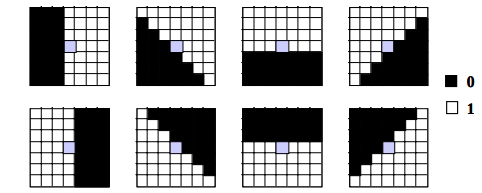

## Preliminaries

In [ ]:
#@title
import ee
 
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

In [ ]:
!ls -l /content/drive/MyDrive

In [ ]:
#@title
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
#@title Refined Lee filter code
# Refined Lee Speckle Filter for S1 images only
# Created on 03.03.2020
# Transcribed from Guido Lemoine's 2017 JavaScript implementation on the GEE
def rl(img):
#   img must be in natural units, and single band
#   Set up 3x3 kernels 
    weights3 = ee.List.repeat(ee.List.repeat(1,3),3)
    kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False)

    mean3 = img.reduceNeighborhood(ee.Reducer.mean(), kernel3)
    variance3 = img.reduceNeighborhood(ee.Reducer.variance(), kernel3)

#  Use a sample of the 3x3 windows inside a 7x7 window to determine gradients and directions
    sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]])

    sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False)

#  Calculate mean and variance for the sampled windows and store as 9 bands
    sample_mean = mean3.neighborhoodToBands(sample_kernel) 
    sample_var = variance3.neighborhoodToBands(sample_kernel)

#  Determine the 4 gradients for the sampled windows
    gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
    gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
    gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
    gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

#  And find the maximum gradient amongst gradient bands
    max_gradient = gradients.reduce(ee.Reducer.max())

#  Create a mask for band pixels that are the maximum gradient
    gradmask = gradients.eq(max_gradient)

#  duplicate gradmask bands: each gradient represents 2 directions
    gradmask = gradmask.addBands(gradmask)

#  Determine the 8 directions
    directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
    directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
    directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
    directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
#  The next 4 are the not() of the previous 4
    directions = directions.addBands(directions.select(0).Not().multiply(5))
    directions = directions.addBands(directions.select(1).Not().multiply(6))
    directions = directions.addBands(directions.select(2).Not().multiply(7))
    directions = directions.addBands(directions.select(3).Not().multiply(8))

#  Mask all values that are not 1-8
    directions = directions.updateMask(gradmask)

#  "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
    directions = directions.reduce(ee.Reducer.sum())

#  var pal = ['ffffff','ff0000','ffff00', '00ff00', '00ffff', '0000ff', 'ff00ff', '000000'];
#  Map.addLayer(directions.reduce(ee.Reducer.sum()), {min:1, max:8, palette: pal}, 'Directions', false);

    sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

#  Calculate localNoiseVariance
    sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

#  Set up the 7*7 kernels for directional statistics
    rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4))

    diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], 
    [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]]);

    rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False)
    diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False)

#  Create stacks for mean and variance using the original kernels. Mask with relevant direction.
    dir_mean = img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1));
    dir_var = img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

    dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
    dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

#  and add the bands for rotated kernels
    for i in range(1,4):
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))

#  "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
    dir_mean = dir_mean.reduce(ee.Reducer.sum())
    dir_var = dir_var.reduce(ee.Reducer.sum())

#  And finally generate the filtered value
    varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))
    b = varX.divide(dir_var)
    result = dir_mean.add(b.multiply(img.subtract(dir_mean)))  
    return result.arrayFlatten([['sum']])

def refinedLee(img):
    return ee.Image.cat(rl(img.select(0)),rl(img.select(1)))
    
if __name__ == '__main__':
    pass

## SAR time series classification




First of all we grab a time series for an area of interest (aoi) in Saskatchewan, Canada over the 2017 growing season (March to October), see [geojson.io](http://geojson.io/#map=2/20.0/0.0):

In [ ]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [[[-105.10328600000001, 50.24327999999998], 
                        [-104.66649400000001, 50.24327999999998], 
                        [-104.66649400000001, 50.46604134048255], 
                        [-105.10328600000001, 50.46604134048255], 
                        [-105.10328600000001, 50.24327999999998]]]}}]}
                        
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

collection = ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
                      .filterBounds(aoi) \
                      .filterDate(ee.Date('2017-03-01'), ee.Date('2017-11-01')) \
                      .filter(ee.Filter.eq('transmitterReceiverPolarisation', ['VV','VH'])) \
                      .filter(ee.Filter.eq('resolution_meters', 10)) \
                      .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                      .filter(ee.Filter.eq('relativeOrbitNumber_start',5)) \
                      .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))  
collection = collection.sort('system:time_start')

collection.size().getInfo()

Next, we transform the collection into a multiband image, with and without pre-processing with the refined Lee filter:

In [ ]:
def get_vvvh(image):   
    ''' get 'VV' and 'VH' bands from sentinel-1 imageCollection '''
    return image.select('VV','VH')
    
timeseries_rl = collection \
            .map(get_vvvh) \
            .map(refinedLee) \
            .toBands() \
            .clip(aoi) 
timeseries = collection \
            .map(get_vvvh) \
            .toBands() \
            .clip(aoi)             

timeseries.bandNames().length().getInfo()

The class lables are conveniently obtained from the GEE archive of the [Canadian AAFC Annual Crop Inventory](https://developers.google.com/earth-engine/datasets/catalog/AAFC_ACI) for the year 2017,  and we append them as an additional band (band 39): 

In [ ]:
crop2017 = ee.ImageCollection('AAFC/ACI') \
    .filter(ee.Filter.date('2017-01-01', '2017-12-01')) \
    .first() \
    .clip(aoi) \
    .float()

labeled_timeseries = ee.Image.cat(timeseries, crop2017).float()
labeled_timeseries_rl = ee.Image.cat(timeseries_rl, crop2017).float()

Here is a projection of the class labels and an rgb composite of three VV bands spaced over the time series using Folium. The fact that the colors are intense is encouraging, as it indicates the time series may be discriminating the crop types fairly well:

In [ ]:
location = aoi.centroid().coordinates().getInfo()[::-1]

timeseries_db = timeseries.log10().multiply(10)
timeseries_rl_db = timeseries_rl.log10().multiply(10)

rgb = ee.Image.rgb(timeseries_db.select(10),timeseries_db.select(20),timeseries_db.select(30))
rgb_rl = ee.Image.rgb(timeseries_rl_db.select(10),timeseries_rl_db.select(20),timeseries_rl_db.select(30))

m = folium.Map(location=location, zoom_start=11, height=800, width=1000)

m.add_ee_layer(rgb, {'min': [-20], 'max': [0]}, 'rgb')
m.add_ee_layer(rgb_rl, {'min': [-20], 'max': [0]}, 'rgb_rl')
m.add_ee_layer(labeled_timeseries.select(38), {'min': 0, 'max': 200}, 'crops')

m.add_child(folium.LayerControl())

We can't run TensorFlow on GEE, so to classify the time series with a neural network classifier we will export the filtered and unfiltered labeled time series to GoogleDrive:

In [ ]:
drexport = ee.batch.Export.image.toDrive(labeled_timeseries_rl,
                  description='driveExportTask', 
                  folder = 'gee',
                  fileNamePrefix='labeled_timeseries_rl',scale=30,maxPixels=1e10)
drexport.start()

In [ ]:
drexport1 = ee.batch.Export.image.toDrive(labeled_timeseries,
                  description='driveExportTask', 
                  folder = 'gee',
                  fileNamePrefix='labeled_timeseries',scale=30,maxPixels=1e10)
drexport1.start()

In [ ]:
!ls -l /content/drive/MyDrive/gee

And then import them into two numpy arrays using _gdal_:

In [ ]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Byte, GDT_Float32
import numpy as np

gdal.AllRegister()             

inDataset = gdal.Open('/content/drive/MyDrive/gee/labeled_timeseries_rl.tif',GA_ReadOnly)
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
labeled_timeseries_rl = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_timeseries_rl[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()   
labeled_timeseries_rl = np.nan_to_num(labeled_timeseries_rl)    

inDataset = gdal.Open('/content/drive/MyDrive/gee/labeled_timeseries.tif',GA_ReadOnly)
labeled_timeseries = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_timeseries[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()   
labeled_timeseries = np.nan_to_num(labeled_timeseries)    

# for later
driver = inDataset.GetDriver() 
inDataset = None
m = labeled_timeseries.shape[0]
labeled_timeseries.shape

The AAFC/ACI thematic maps have 71 different classes. This code generates a dictionary of class names:

In [ ]:
classdict = {'0':'Nc'}
filepath = '/content/drive/MyDrive/scripts/AAFC.txt'
with open(filepath) as fp:
    line = fp.readline()
    key = line[:3].replace('\t','')
    value = line[10:].replace('\t',' ').replace('\n','')
    classdict.update({key:value})
    while line:
        line = fp.readline()
        key = line[:3].replace('\t','')
        value = line[10:].replace('\t','').replace('\n','')
        classdict.update({key:value})
del classdict['']

len(classdict)

Now we can see which class labels pertain to our region of interest:

In [ ]:
classnums = np.unique(labeled_timeseries[:,-1])
print(classnums)
classnames = str([classdict[str(int(cn))] for cn in classnums])
classnames

In order to train the neural network we have to renumber the labels consecutively from 0:

In [ ]:
i=0
labels = labeled_timeseries[:,-1]
for c in classnums:
    labels = np.where(labels==c,i,labels)
    i += 1  
labels = np.array(labels,dtype=np.uint8) 
n_classes = len(np.unique(labels))
print(np.unique(labels))

Here we write the class labels image to the Drive

In [ ]:
outDataset = driver.Create('/content/drive/MyDrive/gee/labels.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(labels,(rows,cols)))
outBand.FlushCache()
outDataset = None

 and display it using the script dispms.py (get help with the -h option):

In [ ]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/labels.tif -c 

Now we simulate ground truth by taking a (generous) random subset of 50k training pixels, one from the unfiltered and one from the filtered time series:

In [ ]:
# random subset for training
np.random.seed(321)
n = 50000
idx = np.random.permutation(m)[0:n]
# training vectors (x100)
Xs = labeled_timeseries[idx,:-1]*100
Xs_rl = labeled_timeseries_rl[idx,:-1]*100

# one hot encoded class labels
Ls = np.array(labels[idx],dtype=np.int)
ls = tf.one_hot(Ls,n_classes)
print(ls[0:5,:])    

Now we instantiate the neural network class Ffn() with two hidden layers, each with 40 neurons:

In [ ]:
classifier = Ffn(Ls=[40,40], K=n_classes, learning_rate=0.002)

And train it on the time series:

In [ ]:
%%time
classifier.train(Xs, ls, epochs=200)

In [ ]:
classifier.history()

So the accuracy is around 82%. Now let's try with the filtered image series, without re-setting the classifier (a foretaste of _transfer learning_, the subject of the next part of the course):

In [ ]:
%%time
classifier.train(Xs_rl, ls, epochs=100)

In [ ]:
classifier.history()

Test the classifier with all of the training data (we should really have reserved a test set for this):

In [ ]:
classifier.test(Xs_rl,ls)

This is a considerable improvement, so we'll use this result to classify (predict) the entire image:

In [ ]:
cls, probs = classifier.classify(labeled_timeseries_rl[:,0:-1]*100) 
# for later display:
cls[0]=1
cls[1]=n_classes-1

probs.shape

Now write the thematic map and the class probabilities images to Drive:

In [ ]:
# write the class image to disk
outDataset = driver.Create('/content/drive/MyDrive/gee/timeseries_class.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(cls,(rows,cols)))
outBand.FlushCache()
outDataset = None
# write the class probabilities to disk
bands = probs.shape[1]
probs = np.byte(probs*255)
outDataset = driver.Create('/content/drive/MyDrive/gee/timeseries_probs.tif',cols,rows,bands,GDT_Float32)
for b in range(bands):
    outBand = outDataset.GetRasterBand(b+1)
    outBand.WriteArray(np.reshape(probs[:,b],(rows,cols)))
    outBand.FlushCache()
outDataset = None

Compare the classified image with the AAFC/ACI thematic map:

In [ ]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/timeseries_class.tif -c -F /content/drive/MyDrive/gee/labels.tif -C 

Looks good, but we can "pretty it up" some more with 

## Probabilistic Label Relaxation:

With a heuristic ansatz  [Richards (2012)](https://www.amazon.de/Remote-Sensing-Digital-Image-Analysis-ebook/dp/B00A9YH460/ref=sr_1_3?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=richards+remote+sensing&qid=1611397419&sr=8-3) the output probability  $m_k$ for an input pixel vector $g$ can be corrected to
$$
m_k \to {m_k Q_k\over \sum_j m_jQ_j},
$$
where $Q$ is a neighbourhood function which can be determined by the contextual information in the classified image, see [Canty (2019)]((https://www.amazon.com/Analysis-Classification-Change-Detection-Sensing/dp/1138613223/ref=dp_ob_title_bk), p. 294.

In [ ]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/timeseries_probs.tif -p [12,14,16] -e 3

In [ ]:
%run /content/drive/MyDrive/scripts/plr /content/drive/MyDrive/gee/timeseries_probs.tif

In [ ]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/timeseries_probs_plr.tif -c  -F /content/drive/MyDrive/gee/timeseries_class.tif -C

### Project
Try to apply a similar procedure to a Sentinel-2 time series.

### Outlook
In the next part of the course we'll leave the subject of polarimetric SAR time series and have a look at "deep learning" classification of Sentinel-2 imagery with convolutional neural networks.